In [1]:
from IPython.display import HTML
from concurrent.futures import ProcessPoolExecutor as PPE

from numpy import arange
import matplotlib.pyplot as plt 

from transformers import AutoProcessor, AutoModel
from torch import cat, save
from decord import VideoReader, cpu
from tqdm import trange

from utils import compute_clip_sim, get_sample_frame_idx

%load_ext autoreload
%autoreload 2

/disk/users/zwu/envs/xclip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "microsoft/xclip-base-patch16-zero-shot"
processor, model = AutoProcessor.from_pretrained(model_name), AutoModel.from_pretrained(model_name)

In [3]:
filename = input()
vr = VideoReader(filename, ctx=cpu(0))
print(len(vr), 'total frames')
HTML(f'<video controls> <source src="{filename}" type="video/mp4"> </video>')

 videos/aerial_small.mp4


6570 total frames


In [4]:
idx, range_per_sample = get_sample_frame_idx(vr, 32)

video_features = []
for i in trange(0, len(idx)):
    # TO-DO  parellel processing
    frames = vr.get_batch(idx[i]).asnumpy()
    video_features.append(
        model.get_video_features(**processor(videos=list(frames), return_tensors="pt"))
    )
    
video_features = cat(video_features); video_features.shape

sample every 24 frames over 767 frames


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


torch.Size([8, 512])

In [60]:
save(video_features, f'feature_vectors/{input()}.pt')

Content matching query found near 63.0s


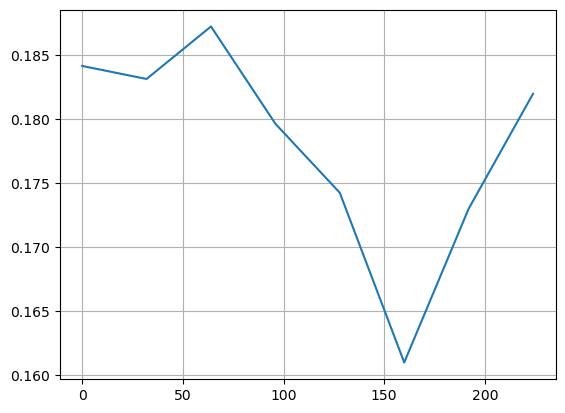

In [5]:
text_features = model.get_text_features(**processor(text=["moving cars"], return_tensors="pt", padding=True))
logits = compute_clip_sim(video_features, text_features)
print(f'Content matching query found near {idx[logits.argmax()][0] // vr.get_avg_fps()}s')

sample_start_time = arange(len(idx)) * range_per_sample / vr.get_avg_fps()
plt.plot(sample_start_time, *logits); plt.grid()#which='both', axis='both')

Content matching query found near 223.0s


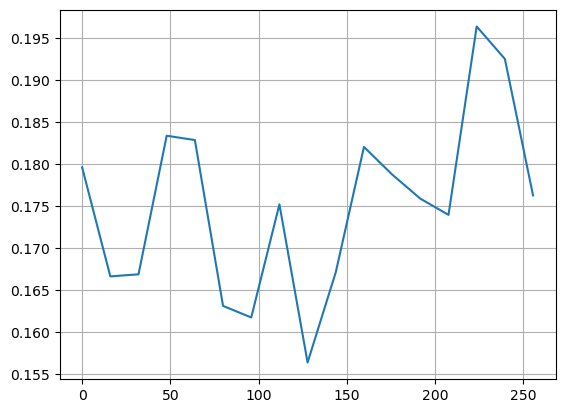

In [59]:
text_features = model.get_text_features(**processor(text=["docked ship"], return_tensors="pt", padding=True))
logits = compute_clip_sim(video_features, text_features)
print(f'Content matching query found near {idx[logits.argmax()][0] // vr.get_avg_fps()}s')

sample_start_time = arange(len(idx)) * range_per_sample / vr.get_avg_fps()
plt.plot(sample_start_time, *logits); plt.grid()#which='both', axis='both')

Content matching query found near 223.0s


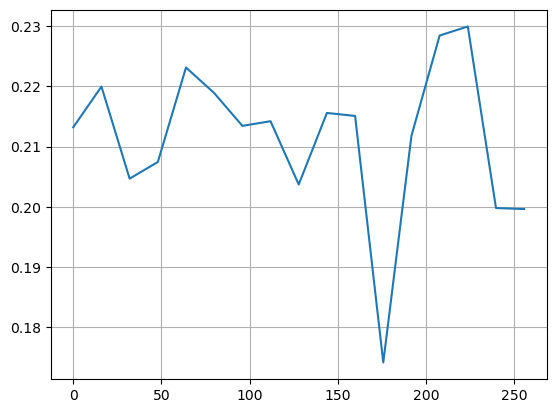

In [57]:
text_features = model.get_text_features(**processor(text=["tower"], return_tensors="pt", padding=True))
logits = compute_clip_sim(video_features, text_features)
print(f'Content matching query found near {idx[logits.argmax()][0] // vr.get_avg_fps()}s')

sample_start_time = arange(len(idx)) * range_per_sample / vr.get_avg_fps()
plt.plot(sample_start_time, *logits); plt.grid()#which='both', axis='both')

In [5]:
### parallel processing issue


# def process_sample(frames):
#     return model.get_video_features(**processor(videos=list(frames), return_tensors="pt"))

# idx, range_per_sample = get_sample_frame_idx(vr, 32)

# fut = []
# with PPE(60) as pool:
#     for i in trange(0, len(idx)):
#         frames = vr.get_batch(idx[i]).asnumpy()
#         fut.append(pool.submit(process_sample, frames))
        
# video_features = [f.result() for f in fut]
# video_features = cat(video_features); video_features.shape

sample every 24 frames over 767 frames


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


RuntimeError: Cowardly refusing to serialize non-leaf tensor which requires_grad, since autograd does not support crossing process boundaries.  If you just want to transfer the data, call detach() on the tensor before serializing (e.g., putting it on the queue).